<a href="https://colab.research.google.com/github/masumcse22/Kidney-Disease-Classification-MLflow-DVC/blob/main/Kidney_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

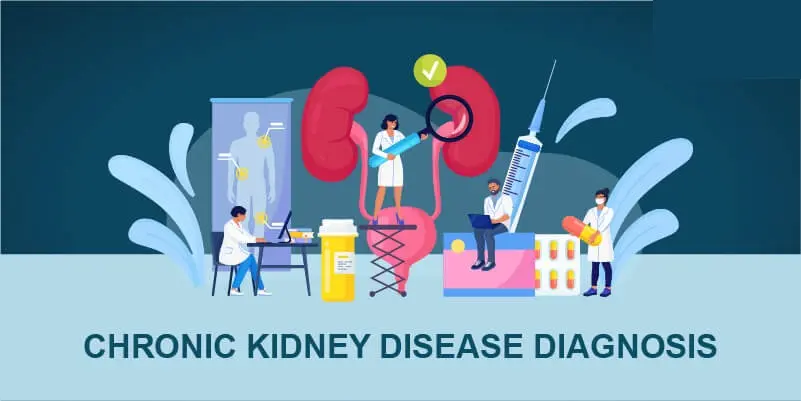

# **Imports Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import random
import warnings

warnings.filterwarnings('ignore')

# Deep Learning Libraries (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras import Sequential, Model, regularizers
from tensorflow.keras.layers import (
    Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout,
    GlobalAveragePooling2D, Activation, Add, GaussianNoise, Reshape,
    SpatialDropout2D, LeakyReLU, ReLU, Lambda, Input
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model, to_categorical

# Data Analysis and Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
import cv2

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Setup Kaggle**

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdmasum789","key":"7742b1ad81c6b6430574aa10bb123b0e"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download dataset
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone


Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors


In [ ]:
#Extracting the contents from zip file
import zipfile
zip_ref = zipfile.ZipFile('/content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip')
zip_ref.extractall('/content')
zip_ref.close()

# **Exploratory Data Analysis for Kidney Disease Prediction: Null Values, Feature Distributions, and Class Balance Visualization**

In [ ]:
base_path = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
categories = ["Cyst", "Normal", "Stone", "Tumor"]

In [ ]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [ ]:
df.head()

,image_path,label
0,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Cyst
1,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Cyst
2,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Cyst
3,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Cyst
4,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Cyst


In [ ]:
df.tail()

,image_path,label
12441,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor
12442,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor
12443,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor
12444,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor
12445,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor


In [ ]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [ ]:
df.shape

(12446, 2)

In [ ]:
df.duplicated().sum()


np.int64(0)

In [ ]:
df.isnull().sum()

,0
image_path,0
label,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  12446 non-null  object
 1   label       12446 non-null  object
dtypes: object(2)
memory usage: 194.6+ KB


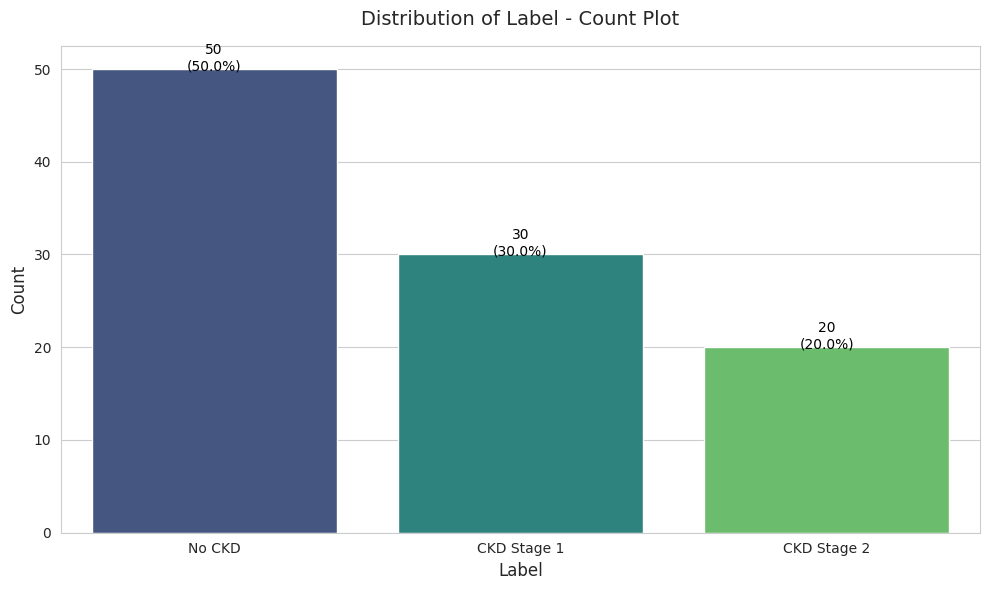

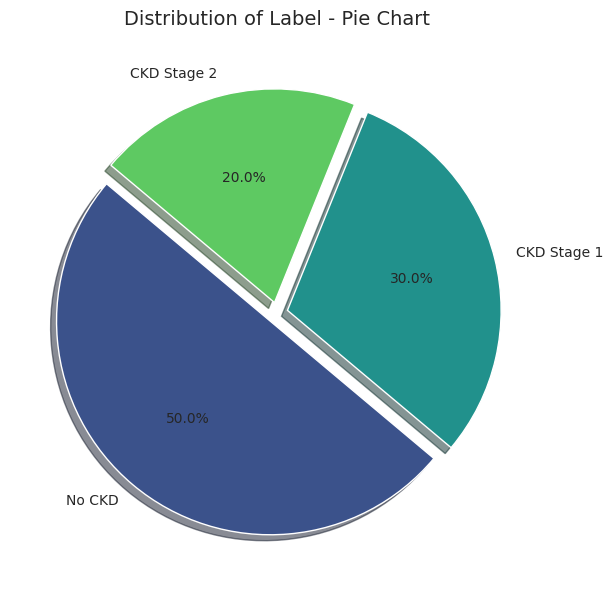

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import warnings
import matplotlib.font_manager as fm

# Suppress specific font-related warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

def visualize_label_distribution(df, label_column="label", figsize=(10, 6), palette="viridis", save_plots=False):
    """
    Visualizes the distribution of labels in a DataFrame using enhanced count plots, pie charts, and interactive plots.

    Args:
        df (pd.DataFrame): The DataFrame containing the label data.
        label_column (str): The name of the column containing the labels. Defaults to "label".
        figsize (tuple): The figure size for static plots. Defaults to (10, 6).
        palette (str): The color palette to use. Defaults to "viridis".
        save_plots (bool): Whether to save the plots as files. Defaults to False.
    """
    # Ensure label column exists
    if label_column not in df.columns:
        raise ValueError(f"Column '{label_column}' not found in DataFrame.")

    # Set style for better aesthetics with fallback fonts
    sns.set_style("whitegrid")
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    preferred_fonts = ["Arial", "Helvetica", "DejaVu Sans", "sans-serif"]
    selected_font = next((font for font in preferred_fonts if font in available_fonts), "sans-serif")
    plt.rcParams["font.family"] = selected_font

    # 1. Enhanced Count Plot with Percentage Annotations
    plt.figure(figsize=figsize)
    total = len(df)
    ax = sns.countplot(data=df, x=label_column, palette=palette, hue=label_column, legend=False)

    # Add percentage and count annotations
    for p in ax.patches:
        count = int(p.get_height())
        percentage = f"{100 * count / total:.1f}%"
        ax.annotate(f"{count}\n({percentage})",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha="center", va="center", fontsize=10, color="black",
                    xytext=(0, 8), textcoords="offset points")

    plt.title(f"Distribution of {label_column.capitalize()} - Count Plot", fontsize=14, pad=15)
    plt.xlabel(label_column.capitalize(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    if save_plots:
        plt.savefig(f"count_plot_{label_column}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 2. Enhanced Pie Chart
    label_counts = df[label_column].value_counts()
    plt.figure(figsize=figsize)
    colors = sns.color_palette(palette, len(label_counts))
    explode = [0.05] * len(label_counts)  # Slightly separate slices
    plt.pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", startangle=140,
            colors=colors, explode=explode, shadow=True, textprops={"fontsize": 10})
    plt.title(f"Distribution of {label_column.capitalize()} - Pie Chart", fontsize=14, pad=15)
    plt.tight_layout()

    if save_plots:
        plt.savefig(f"pie_chart_{label_column}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 3. Interactive Bar Plot with Plotly
    fig = px.bar(x=label_counts.index, y=label_counts.values,
                 color=label_counts.index,
                 color_discrete_sequence=sns.color_palette(palette).as_hex(),
                 text=[f"{count} ({100 * count / total:.1f}%)" for count in label_counts.values])
    fig.update_layout(
        title=f"Interactive Distribution of {label_column.capitalize()}",
        xaxis_title=label_column.capitalize(),
        yaxis_title="Count",
        showlegend=False,
        font=dict(size=12),
        template="plotly_white",
        height=figsize[1] * 100
    )
    fig.update_traces(textposition="outside", textfont=dict(size=10))
    if save_plots:
        fig.write_image(f"interactive_bar_{label_column}.png")
    fig.show()

    # 4. Donut Chart with Plotly
    fig = go.Figure(data=[go.Pie(
        labels=label_counts.index,
        values=label_counts.values,
        hole=0.4,  # Creates donut effect
        marker_colors=sns.color_palette(palette).as_hex(),
        textinfo="label+percent",
        textfont=dict(size=10)
    )])
    fig.update_layout(
        title=f"Donut Chart of {label_column.capitalize()}",
        showlegend=True,
        font=dict(size=12),
        template="plotly_white",
        height=figsize[1] * 100
    )
    if save_plots:
        fig.write_image(f"donut_chart_{label_column}.png")
    fig.show()

# Example usage with sample kidney disease data
if __name__ == "__main__":
    data = {
        "label": ["No CKD"] * 50 + ["CKD Stage 1"] * 30 + ["CKD Stage 2"] * 20
    }
    df = pd.DataFrame(data)
    visualize_label_distribution(df, label_column="label")

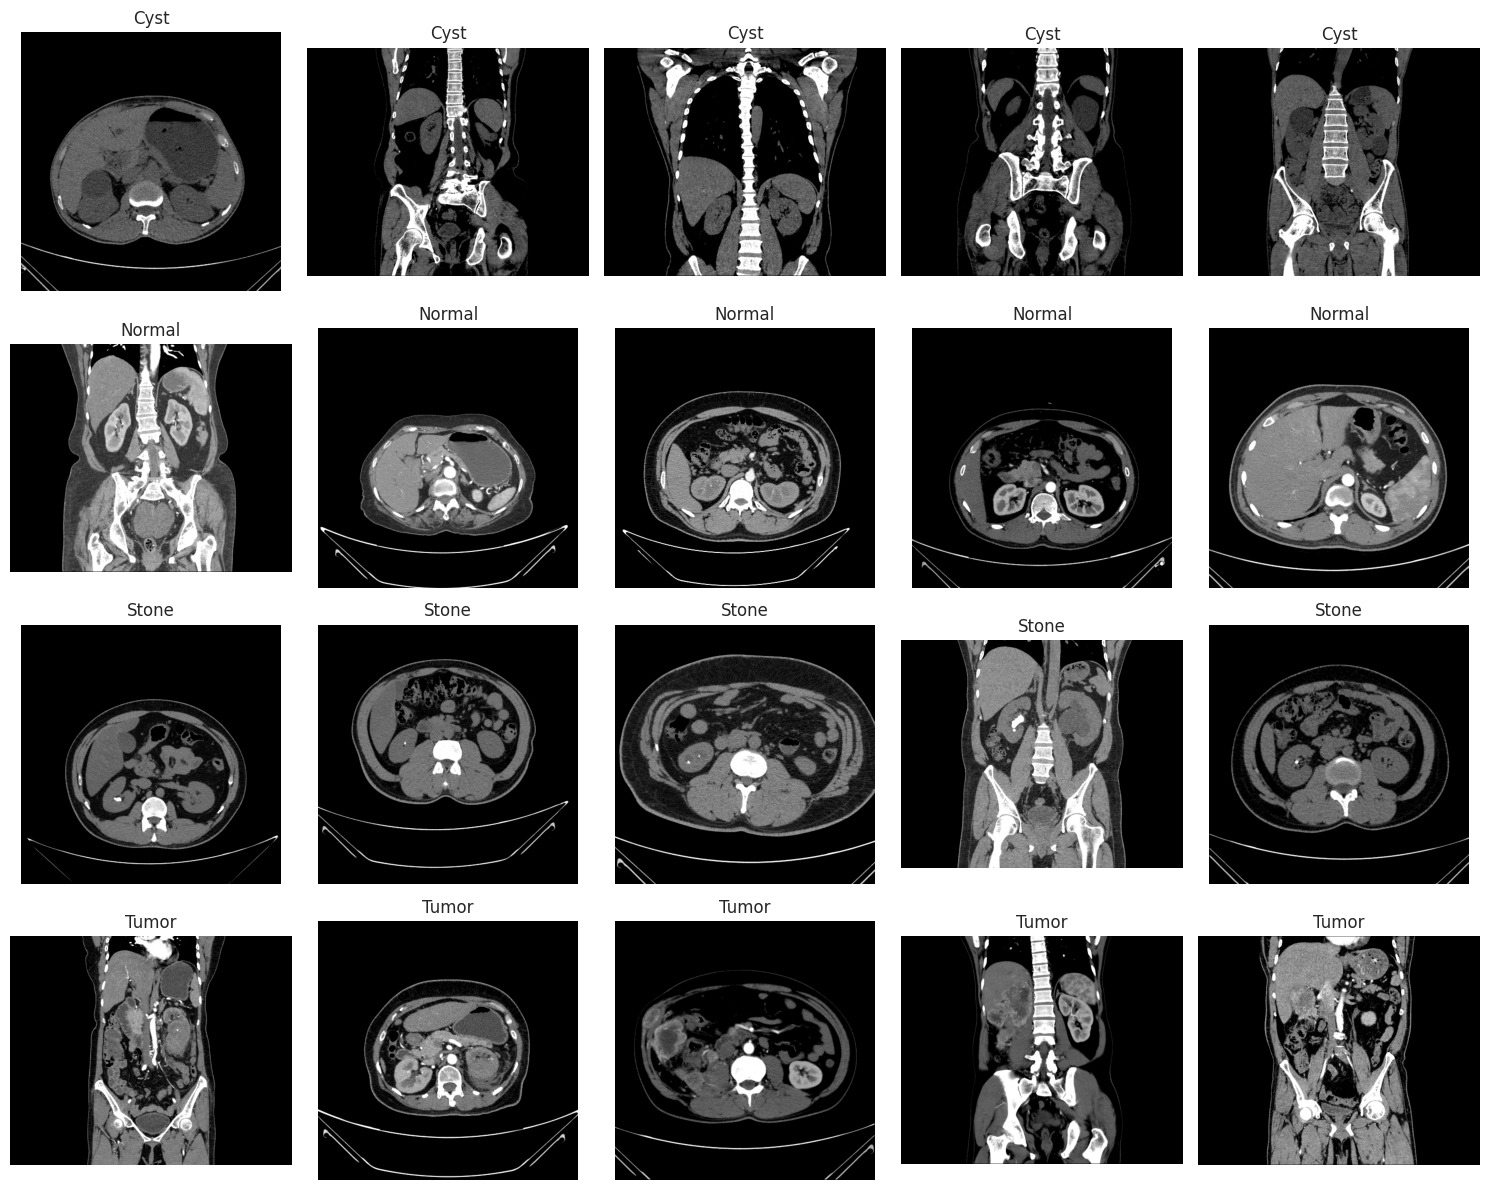

In [ ]:
import cv2

num_images = 5

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [ ]:
df = df[['image_path', 'category_encoded']]

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])

df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled

In [ ]:
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    5077
1    5077
2    5077
3    5077
Name: count, dtype: int64


In [ ]:
df_resampled

,image_path,category_encoded
0,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0
1,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0
2,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0
3,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0
4,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0
...,...,...
20303,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,3
20304,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,3
20305,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,3
20306,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,3


In [ ]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

# **Performance Evaluation of Vision Transformer for Kidney Disease Classification: Accuracy, Loss, and Confusion Matrix Analysis**

## **Importing Libraries for Deep Learning Model**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


## **Splitting Data into Training, Validation, and Test Sets**


In [ ]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded']
)

## **Image Data Generators for Training, Validation, and Testing**

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)
valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)
test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 16246 validated image filenames belonging to 4 classes.
Found 2031 validated image filenames belonging to 4 classes.
Found 2031 validated image filenames belonging to 4 classes.


In [ ]:
# Checking Available GPUs in TensorFlow
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## **Configuring GPU Memory Growth for TensorFlow**

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set for TensorFlow")
    except RuntimeError as e:
        print(e)

GPU is set for TensorFlow


In [ ]:
# Importing Keras Callbacks for Early Stopping and Model Checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Configuring Early Stopping for Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## **Implementing Vision Transformer (ViT) Model**

In [ ]:
from tensorflow.keras import layers

class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = layers.Conv2D(embed_dim, patch_size, strides=patch_size, padding='valid')

    def call(self, images):
        patches = self.proj(images)
        patches = tf.reshape(patches, (tf.shape(patches)[0], -1, self.embed_dim))
        return patches

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads, embed_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

    def call(self, inputs):
        return self.attention(inputs, inputs)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadSelfAttention(num_heads, embed_dim)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='gelu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate)
        ])

    def call(self, inputs):
        x = self.layernorm1(inputs)
        x = self.attention(x)
        x = x + inputs
        x = self.layernorm2(x)
        x = self.mlp(x)
        return x + inputs

class VisionTransformer(tf.keras.Model):
    def __init__(self, image_size, patch_size, embed_dim, num_heads, num_blocks, mlp_dim, num_classes, dropout_rate=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(patch_size, embed_dim)

        height, width, _ = image_size
        num_patches = (height // patch_size) * (width // patch_size)

        self.pos_embed = self.add_weight(
            name="pos_embed",
            shape=(1, num_patches + 1, embed_dim),
            initializer=tf.initializers.RandomNormal(stddev=0.02),
            trainable=True
        )

        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, embed_dim),
            initializer=tf.initializers.RandomNormal(stddev=0.02),
            trainable=True
        )

        self.dropout = layers.Dropout(dropout_rate)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, mlp_dim, dropout_rate) for _ in range(num_blocks)]
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = self.patch_embed(images)

        cls_tokens = tf.repeat(self.cls_token, repeats=batch_size, axis=0)
        x = tf.concat([cls_tokens, patches], axis=1)

        pos_embed = tf.repeat(self.pos_embed, repeats=batch_size, axis=0)
        x = x + pos_embed
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.layernorm(x)
        cls_token_final = x[:, 0]
        return self.classifier(cls_token_final)


image_size = (224, 224, 3)
patch_size = 16
embed_dim = 256
num_heads = 8
num_blocks = 6
mlp_dim = 256
num_classes = 4
dropout_rate = 0.1
learning_rate = 1e-5

vit_model = VisionTransformer(image_size=image_size,
                              patch_size=patch_size,
                              embed_dim=embed_dim,
                              num_heads=num_heads,
                              num_blocks=num_blocks,
                              mlp_dim=mlp_dim,
                              num_classes=num_classes,
                              dropout_rate=dropout_rate)

vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

## **Training Vision Transformer Model**


In [ ]:
epochs = 3
history = vit_model.fit(train_gen_new, epochs=epochs, batch_size = 32, validation_data=valid_gen_new)

Epoch 1/3
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 220s 188ms/step - accuracy: 0.4561 - loss: 1.1643 - val_accuracy: 0.8099 - val_loss: 0.4703
Epoch 2/3
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 184s 181ms/step - accuracy: 0.8867 - loss: 0.3050 - val_accuracy: 0.9714 - val_loss: 0.0840
Epoch 3/3
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 183s 180ms/step - accuracy: 0.9786 - loss: 0.0665 - val_accuracy: 1.0000 - val_loss: 0.0117


## **Plotting Training and Validation Accuracy and Loss**

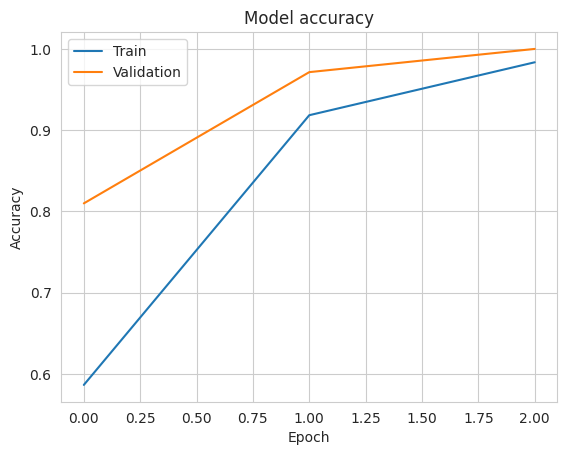

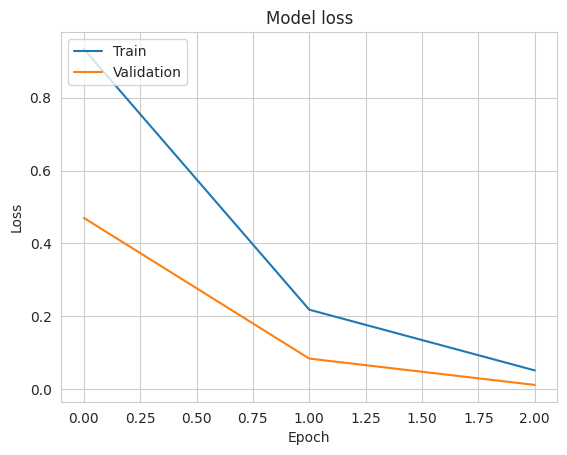

In [ ]:
# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Making Predictions and Evaluating Model on Test Set**

In [ ]:
test_labels = test_gen_new.classes
predictions = vit_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step


## **Generating and Printing Classification Report**

In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       508
           1       1.00      1.00      1.00       508
           2       1.00      1.00      1.00       508
           3       1.00      1.00      1.00       507

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [ ]:
# Generating Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

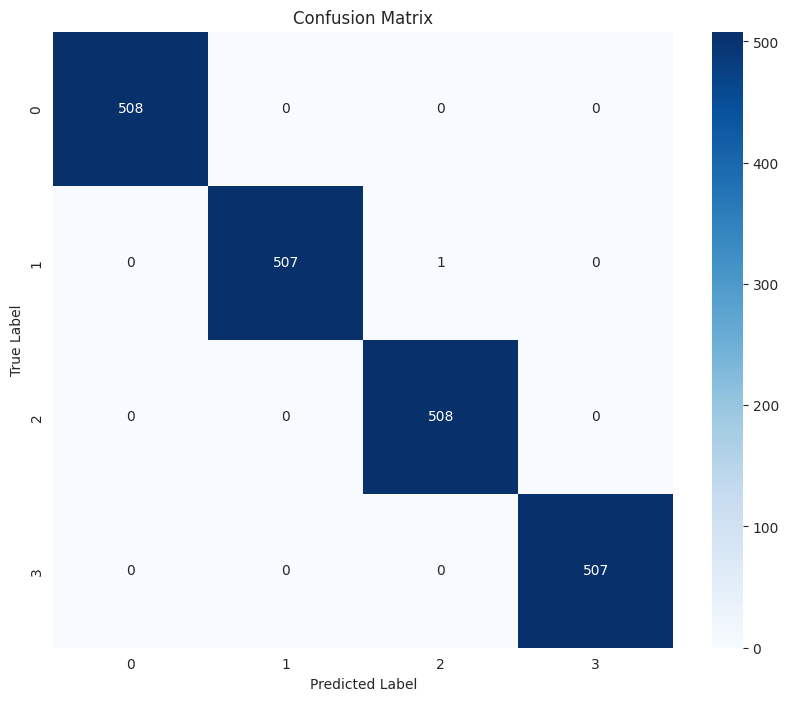

In [ ]:
# Plotting Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Performance Evaluation of Swin Transformer for Kidney Disease Classification: Accuracy, Loss, and Confusion Matrix Analysis**

## **Implementing Swin Transformer Model**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class WindowAttention(layers.Layer):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=False)
        self.proj = layers.Dense(dim)
        self.window_size = window_size

    def call(self, x):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        qkv = self.qkv(x)
        qkv = tf.reshape(qkv, (B, N, 3, self.num_heads, C // self.num_heads))
        qkv = tf.transpose(qkv, [2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = tf.nn.softmax(attn)
        x = tf.matmul(attn, v)
        x = tf.transpose(x, [0, 2, 1, 3])
        x = tf.reshape(x, (B, N, C))
        return self.proj(x)

class SwinTransformerBlock(layers.Layer):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.norm1 = layers.LayerNormalization()
        self.attn = WindowAttention(dim, num_heads, window_size)
        self.norm2 = layers.LayerNormalization()
        self.mlp = keras.Sequential([
            layers.Dense(dim * 4, activation='gelu'),
            layers.Dense(dim)
        ])

    def call(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class SwinTransformer(layers.Layer):
    def __init__(self, input_shape, patch_size=4, embed_dim=96, num_heads=3, window_size=7):
        super().__init__()
        self.patch_embed = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='same')
        self.swin_block = SwinTransformerBlock(embed_dim, num_heads, window_size)
        self.pool = layers.GlobalAveragePooling1D()
        self.fc = layers.Dense(4, activation='softmax')

    def call(self, x):
        x = self.patch_embed(x)
        x = tf.reshape(x, (tf.shape(x)[0], -1, x.shape[-1]))
        x = self.swin_block(x)
        x = self.pool(x)
        return self.fc(x)

input_shape = (224, 224, 3)
model = keras.Sequential([
    layers.Input(shape=input_shape),
    SwinTransformer(input_shape)
])

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ swin_transformer                │ (None, 4)              │       116,644 │
│ (SwinTransformer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,644 (455.64 KB)

 Trainable params: 116,644 (455.64 KB)

 Non-trainable params: 0 (0.00 B)

## **Compiling and Training the Swin Transformer Model**


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5
)

Epoch 1/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 194s 181ms/step - accuracy: 0.4279 - loss: 1.2049 - val_accuracy: 0.5844 - val_loss: 0.9233
Epoch 2/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 186s 183ms/step - accuracy: 0.6306 - loss: 0.8457 - val_accuracy: 0.6933 - val_loss: 0.6978
Epoch 3/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 188s 184ms/step - accuracy: 0.7340 - loss: 0.6499 - val_accuracy: 0.8070 - val_loss: 0.5379
Epoch 4/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 175s 172ms/step - accuracy: 0.7967 - loss: 0.5341 - val_accuracy: 0.7558 - val_loss: 0.5541
Epoch 5/5
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 175s 172ms/step - accuracy: 0.8286 - loss: 0.4508 - val_accuracy: 0.7986 - val_loss: 0.4650


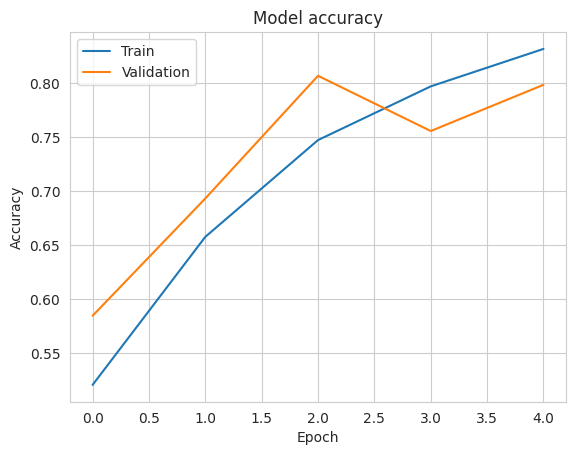

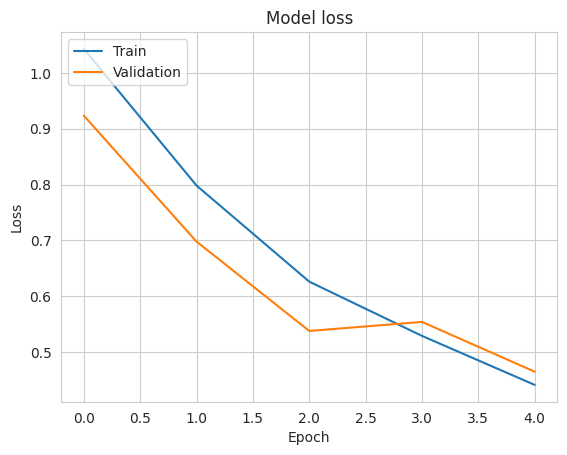

In [ ]:
# Plotting Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Calculate the confusion matrix**

In [ ]:
test_labels = test_gen_new.classes
predictions = model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step


In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.92      0.64      0.75       508
           1       0.89      0.92      0.91       508
           2       0.63      0.96      0.76       508
           3       0.92      0.69      0.79       507

    accuracy                           0.80      2031
   macro avg       0.84      0.80      0.80      2031
weighted avg       0.84      0.80      0.80      2031



In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

In [ ]:
conf_matrix

array([[325,   1, 165,  17],
       [  1, 469,  26,  12],
       [  2,  16, 489,   1],
       [ 26,  39,  94, 348]])

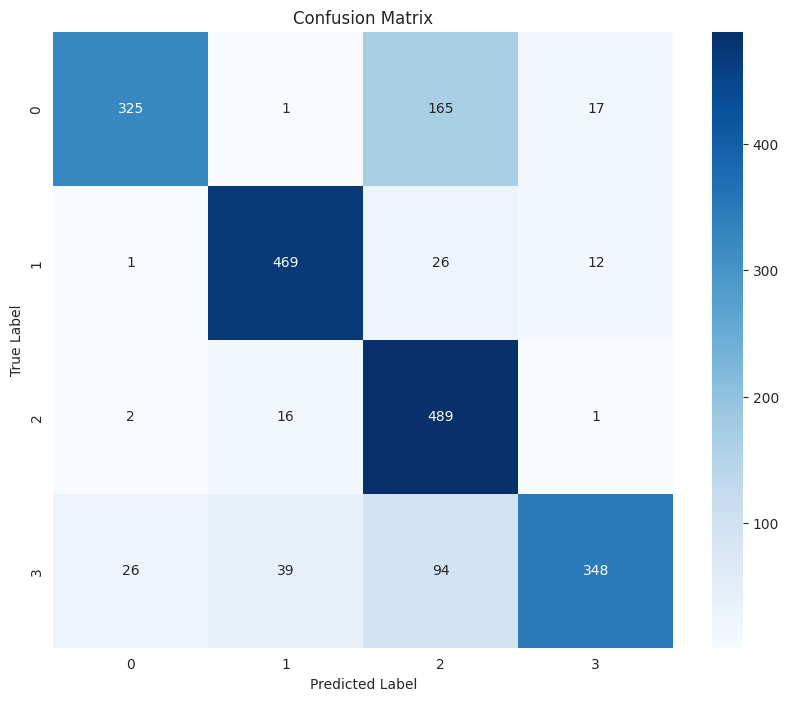

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()